In [338]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skimage.color import rgb2gray

import tifffile as TIFF
from matplotlib import cm
import scipy.io
from skimage import measure

import PyPlaque
from PyPlaque.experiment import ExperimentFluorescencePlaque
from PyPlaque.phenotypes import Plaque, FluorescencePlaque
from PyPlaque.specimen import (PlaquesImageGray, PlaquesImageRGB, PlaquesMask, PlaquesWell,
                                PlateImage)
from PyPlaque.utils import centroid, check_numbers, fixed_threshold, stitch_wells, get_plaque_mask, \
      getAllPlaqueRegions, remove_background, remove_artifacts, PlaqueImageReadout

np.random.seed(0)


In [340]:
# Here we will pick some random rows from the CSV of matlab results and get similar results from PyPlaque

# matlab_results_image = pd.read_csv("../../../../data_backup/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/200601-zplate-g2_ImageData.csv", header = 0)
# matlab_results_object = pd.read_csv("../../../../data_backup/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/200601-zplate-g2_ObjectData.csv", header = 0)

matlab_results_image = pd.read_csv(r"E:\PLAQUE\data\Matlab_results\200601-zplate-g2_ImageData.csv", header = 0)
matlab_results_object = pd.read_csv(r"E:\PLAQUE\data\Matlab_results\200601-zplate-g2_ObjectData.csv", header = 0)

In [341]:
import scipy.io
mat = scipy.io.loadmat(r'E:\PLAQUE\data\Matlab_results\24_05_13_parameters.mat')
print(mat['parameters'])

[[(array([[(array([[0]], dtype=uint8), array([[0]], dtype=uint8), array([[1]], dtype=uint8), array([[1]], dtype=uint8), array(['E:\\PLAQUE\\data\\200601-zplate-g2\\2020-06-03\\2072'],
                dtype='<U47'), array(['(?<wellName>[A-Z][0-9]*)_s1_(?<channelName>w[0-9]*).tif'],
                dtype='<U55'), array(['200601-zplate-g2'], dtype='<U16'), array(['E:\\PLAQUE\\data\\results'], dtype='<U22'))                                                         ]],
        dtype=[('stitchFlag', 'O'), ('maskFlag', 'O'), ('nucleiFlag', 'O'), ('virusFlag', 'O'), ('processingFolder', 'O'), ('fileNamePattern', 'O'), ('plateName', 'O'), ('resultOutputFolder', 'O')]), array([[(array([[0.5]]), array(['w1'], dtype='<U2'), array(['manualThresholding'], dtype='<U18'), array([[0.008]]), array([[80]], dtype=uint8), array([[90]], dtype=uint8), array([[1]], dtype=uint8), array([[120]], dtype=uint8))]],
        dtype=[('artifactThreshold', 'O'), ('selectedChannel', 'O'), ('selectedThresholdingMethod', '

In [342]:
# For plaque channel
params_w2 = mat['parameters'][0][0][2][0]
params_w2_names = list(params_w2.dtype.fields.keys())

params_w2_dict = dict()

for i, p in enumerate(params_w2.tolist()[0]):
  if params_w2_names[i] == 'selectedChannel':
    params_w2_dict[params_w2_names[i]] = p[0]
  else:
    params_w2_dict[params_w2_names[i]] = p[0][0]
  print(f'{params_w2_names[i]}:{p}')


selectedChannel:['w2']
virusThreshold:[[0.032]]
minPlaqueArea:[[2000]]
plaqueConnectivity:[[6]]
minCellArea:[[80]]
maxCellArea:[[90]]
finePlaqueDetectionFlag:[[1]]
plaqueGaussianFilterSize:[[200]]
plaqueGaussianFilterSigma:[[100]]
peakRegionSize:[[50]]


In [343]:
params_w2_dict


{'selectedChannel': 'w2',
 'virusThreshold': 0.032,
 'minPlaqueArea': 2000,
 'plaqueConnectivity': 6,
 'minCellArea': 80,
 'maxCellArea': 90,
 'finePlaqueDetectionFlag': 1,
 'plaqueGaussianFilterSize': 200,
 'plaqueGaussianFilterSigma': 100,
 'peakRegionSize': 50}

In [344]:
mat


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon May 13 03:10:29 2024',
 '__version__': '1.0',
 '__globals__': [],
 'parameters': array([[(array([[(array([[0]], dtype=uint8), array([[0]], dtype=uint8), array([[1]], dtype=uint8), array([[1]], dtype=uint8), array(['E:\\PLAQUE\\data\\200601-zplate-g2\\2020-06-03\\2072'],
                       dtype='<U47'), array(['(?<wellName>[A-Z][0-9]*)_s1_(?<channelName>w[0-9]*).tif'],
                       dtype='<U55'), array(['200601-zplate-g2'], dtype='<U16'), array(['E:\\PLAQUE\\data\\results'], dtype='<U22'))                                                         ]],
               dtype=[('stitchFlag', 'O'), ('maskFlag', 'O'), ('nucleiFlag', 'O'), ('virusFlag', 'O'), ('processingFolder', 'O'), ('fileNamePattern', 'O'), ('plateName', 'O'), ('resultOutputFolder', 'O')]), array([[(array([[0.5]]), array(['w1'], dtype='<U2'), array(['manualThresholding'], dtype='<U18'), array([[0.008]]), array([[80]], dtype=uint8), array([

In [345]:
# For nuclei channel
params_w1 = mat['parameters'][0][0][1][0]
params_w1_names = list(params_w1.dtype.fields.keys())

params_w1_dict = dict()

for i, p in enumerate(params_w1.tolist()[0]):
  if params_w1_names[i] == 'selectedChannel' or 'selectedThresholdingMethod':
    params_w1_dict[params_w1_names[i]] = p[0]
  else:
    params_w1_dict[params_w1_names[i]] = float(p[0][0])

  print(f'{params_w1_names[i]}:{p[0][0]}')


artifactThreshold:0.5
selectedChannel:w
selectedThresholdingMethod:m
manualThreshold:0.008
minCellArea:80
maxCellArea:90
illuminationCorrectionFlag:1
correctionBallRadius:120


In [346]:
params_w1_dict


{'artifactThreshold': array([0.5]),
 'selectedChannel': 'w1',
 'selectedThresholdingMethod': 'manualThresholding',
 'manualThreshold': array([0.008]),
 'minCellArea': array([80], dtype=uint8),
 'maxCellArea': array([90], dtype=uint8),
 'illuminationCorrectionFlag': array([1], dtype=uint8),
 'correctionBallRadius': array([120], dtype=uint8)}

In [347]:
matlab_results_image.head()


,NucleiImageName,wellRow,wellCollumn,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,VirusImageName,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
0,200601-zplate-g2_A01_s1_w1.tif,A,1,32308,9286469919,2214.066963,12953,200601-zplate-g2_A01_s1_w2.tif,37322,7327763701,1747.075010,32,1730
1,200601-zplate-g2_A02_s1_w1.tif,A,2,44135,9155474320,2182.835178,12905,200601-zplate-g2_A02_s1_w2.tif,45051,7505195868,1789.378135,30,1632
2,200601-zplate-g2_A03_s1_w1.tif,A,3,39825,9249109411,2205.159524,12944,200601-zplate-g2_A03_s1_w2.tif,31160,7630521258,1819.258036,41,2124
3,200601-zplate-g2_A04_s1_w1.tif,A,4,32732,9107313173,2171.352666,12830,200601-zplate-g2_A04_s1_w2.tif,53822,7526026914,1794.344643,29,1791
4,200601-zplate-g2_A05_s1_w1.tif,A,5,65535,9163849879,2184.832067,12394,200601-zplate-g2_A05_s1_w2.tif,51669,7437289993,1773.188112,28,1657


In [348]:
matlab_results_object.head()


,Area,Centroid_1,Centroid_2,BoundingBox_1,BoundingBox_2,BoundingBox_3,BoundingBox_4,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Roundness,numberOfPeaks,numberOfNucleiInPlaque,numberOfInfectedNucleiInPlaque,wellRow,wellCollumn,maxIntensityGFP,totalIntensityGFP,meanIntensity
0,7875,159.381460,391.374857,101.5,311.5,118,150,147.367646,105.891989,0.695469,12010,0.903621,1,49,43,A,1,6756,39932172,2256.054915
1,2660,346.100752,1048.833083,290.5,1010.5,145,88,124.674397,64.299545,0.856745,8140,0.781274,1,27,22,A,1,9554,25677254,2012.323981
2,3785,370.363276,348.663144,332.5,309.5,80,77,80.530378,63.163171,0.620332,4467,0.954889,1,20,20,A,1,6256,16998702,2759.529545
3,6552,444.012210,1716.326465,384.5,1650.5,120,132,134.721614,71.944665,0.845469,9226,0.811868,1,29,25,A,1,13637,41453406,2617.007955
4,2883,449.473118,764.695803,395.5,727.5,88,88,85.257718,55.990305,0.754136,4883,0.854728,1,21,14,A,1,9431,20010399,2583.987474


In [349]:
channel_1_identifier = 'w1'
channel_2_identifier = 'w2'


In [350]:
# Sampling a bunch of rows from the csv
matlab_results_image_w2 = matlab_results_image.loc[matlab_results_image['VirusImageName'].str. \
                                                   contains(channel_2_identifier, case=True)]
print(matlab_results_image_w2.shape)
sample_matlab_results_image_w2 = matlab_results_image_w2.sample(n=20, replace=False, random_state=1)
print(sample_matlab_results_image_w2.shape)


(384, 13)
(20, 13)


In [351]:
#Now we will try to find the corresponding images and process them
#For images it is easy since we only need to indentify the well which is easy from the image name
#itself, for objects it is a bit difficult since we need to lookup and match the centroid

#loading multiple plates and plate masks as an experiment
# exp = ExperimentFluorescencePlaque('../../../../data_backup/samples_fluorescent_plaques/images',
#                                    '../../../../data_backup/samples_fluorescent_plaques/masks')
exp = ExperimentFluorescencePlaque('E:\\PLAQUE\\data\\test_data',
                                   'E:\\PLAQUE\\masks')
#In this case the individual plates are of 384 well plates for fluorescence plaques and
#their corresponding mask directories
plate_dirs, plate_mask_dirs = exp.get_individual_plates()

print(plate_dirs, plate_mask_dirs)

print(exp.get_number_of_plates())
#This number is accurate but we are choosing to ignore other plates other than just one


['200601-zplate-g2'] []
1


In [352]:
params_w2_dict


{'selectedChannel': 'w2',
 'virusThreshold': 0.032,
 'minPlaqueArea': 2000,
 'plaqueConnectivity': 6,
 'minCellArea': 80,
 'maxCellArea': 90,
 'finePlaqueDetectionFlag': 1,
 'plaqueGaussianFilterSize': 200,
 'plaqueGaussianFilterSigma': 100,
 'peakRegionSize': 50}

In [353]:
#force ploting in new window    
image_bits = 16
params_w2 = {
    'min_plaque_area': params_w2_dict['minPlaqueArea'],
    'virus_threshold': params_w2_dict['virusThreshold']* (2**image_bits - 1),
    'plaque_connectivity': params_w2_dict['plaqueConnectivity'],
    'fine_plaque_detection_flag': True if params_w2_dict['finePlaqueDetectionFlag']==1 else False,
    'plaque_gaussian_filter_size': params_w2_dict['plaqueGaussianFilterSize'],
    'plaque_gaussian_filter_sigma': params_w2_dict['plaqueGaussianFilterSigma'],
    'peak_region_size': params_w2_dict['peakRegionSize'],
    'minCellArea': params_w1_dict['minCellArea'][0],
    'maxCellArea': params_w1_dict['maxCellArea'][0]
}



plate_dict_w2 = {}

d = plate_dirs[0]

i = 1
plate_dict_w2[d] = {}
plate_dict_w2[d]['img'] = {}
plate_dict_w2[d]['mask'] = {}
plate_dict_w2[d]['image_name'] = {}
image_files_for_comparison = list(sample_matlab_results_image_w2['VirusImageName'])
image_files_for_comparison = [os.path.join(exp.plate_folder,d,'2020-06-03','2072',f) 
                                for f in image_files_for_comparison]
print(image_files_for_comparison)
for f in image_files_for_comparison:
    plate_dict_w2[d]['img'][i] = TIFF.imread(f)
    plate_dict_w2[d]['image_name'][i] = f
    plate_dict_w2[d]['mask'][i],_ = get_plaque_mask(plate_dict_w2[d]['img'][i],params_w2)
    i+=1



['E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_K17_s1_w2.tif', 'E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_E11_s1_w2.tif', 'E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_F03_s1_w2.tif', 'E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_C15_s1_w2.tif', 'E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_H18_s1_w2.tif', 'E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_L20_s1_w2.tif', 'E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_F20_s1_w2.tif', 'E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_D24_s1_w2.tif', 'E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_K19_s1_w2.tif', 'E:\\PLAQUE\\data\\test_data\\200601-zplate-g2\\2020-06-03\\2072\\200601-zplate-g2_F08_s1_w2.tif', 'E:\\PLAQ

c:\Python311\Lib\site-packages\scipy\ndimage\_filters.py:187: RuntimeWarning: overflow encountered in scalar multiply
  sigma2 = sigma * sigma


In [354]:
matlab_results_image.loc[(matlab_results_image['wellRow']=='E')&(matlab_results_image['wellCollumn']==11)]


,NucleiImageName,wellRow,wellCollumn,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,VirusImageName,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
106,200601-zplate-g2_E11_s1_w1.tif,E,11,38224,8807668434,2099.911793,11935,200601-zplate-g2_E11_s1_w2.tif,35317,7183057188,1712.574288,32,1485


E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_E11_s1_w2.tif


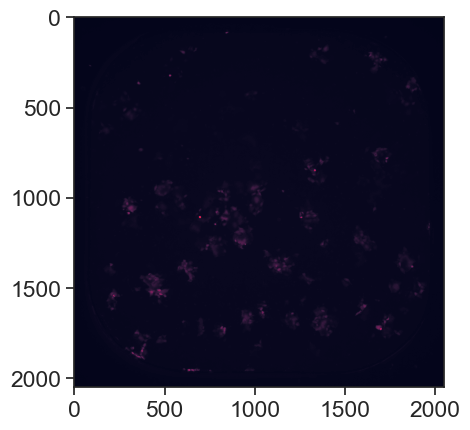

In [260]:
print(plate_dict_w2['200601-zplate-g2']['image_name'][2])
plt.imshow(plate_dict_w2['200601-zplate-g2']['img'][2])


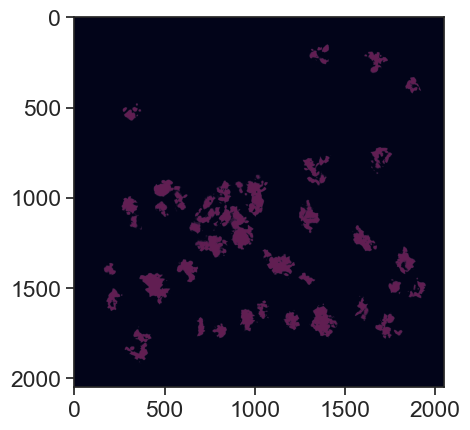

In [294]:
plt.imshow(plate_dict_w2['200601-zplate-g2']['mask'][2],vmin=0,vmax=4)


In [355]:
img_list_w2 = list(plate_dict_w2[plate_dirs[0]]['img'].values())
len(img_list_w2)


20

In [356]:
params_w1_dict


{'artifactThreshold': array([0.5]),
 'selectedChannel': 'w1',
 'selectedThresholdingMethod': 'manualThresholding',
 'manualThreshold': array([0.008]),
 'minCellArea': array([80], dtype=uint8),
 'maxCellArea': array([90], dtype=uint8),
 'illuminationCorrectionFlag': array([1], dtype=uint8),
 'correctionBallRadius': array([120], dtype=uint8)}

In [357]:
image_bits = 16
params_w1 = {
    'selected_thresholding_method': params_w1_dict['selectedThresholdingMethod'],
    'manual_threshold': params_w1_dict['manualThreshold'][0]* (2**image_bits - 1),
    'artifact_threshold': params_w1_dict['artifactThreshold'][0]* (2**image_bits - 1),
    'minCellArea': params_w1_dict['minCellArea'][0],
    'maxCellArea': params_w1_dict['maxCellArea'][0],
    'illuminationCorrectionFlag': True if params_w1_dict['illuminationCorrectionFlag'] == 0 else False,
    'correctionBallRadius': 120
}

print(params_w1)
plate_dict_w1 = {}

d = plate_dirs[0]

i = 1
plate_dict_w1[d] = {}
plate_dict_w1[d]['img'] = {}
plate_dict_w1[d]['mask'] = {}
plate_dict_w1[d]['image_name'] = {}
image_files_for_comparison = list(sample_matlab_results_image_w2['NucleiImageName'])
image_files_for_comparison = [os.path.join(exp.plate_folder,d,'2020-06-03','2072',f)
                                for f in image_files_for_comparison]
for f in image_files_for_comparison:
    print(f)
    plate_dict_w1[d]['img'][i] = TIFF.imread(f)
    plate_dict_w1[d]['image_name'][i] = f
    artifact_removed_img = remove_artifacts(plate_dict_w1[d]['img'][i],
                                        artifact_threshold=params_w1['artifact_threshold'])
    bg, bg_removed_img = remove_background(artifact_removed_img,
                        radius=params_w1['correctionBallRadius'])
     
    # regular thresholding
    binary = np.where(bg_removed_img > params_w1['manual_threshold'], 1, 0)
    plate_dict_w1[d]['mask'][i] = binary

    # Plotting
    # plt.figure()
    # plt.imshow(binary, cmap='gray')
    # plt.show()
    i+=1


{'selected_thresholding_method': 'manualThresholding', 'manual_threshold': 524.28, 'artifact_threshold': 32767.5, 'minCellArea': 80, 'maxCellArea': 90, 'illuminationCorrectionFlag': False, 'correctionBallRadius': 120}
E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_K17_s1_w1.tif
E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_E11_s1_w1.tif
E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_F03_s1_w1.tif
E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_C15_s1_w1.tif
E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_H18_s1_w1.tif
E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_L20_s1_w1.tif
E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_F20_s1_w1.tif
E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2_D24_s1_w1.tif
E:\PLAQUE\data\test_data\200601-zplate-g2\2020-06-03\2072\200601-zplat

In [358]:
img_list_w1 = list(plate_dict_w1[plate_dirs[0]]['img'].values())
len(img_list_w1)


20

In [359]:
abs_df_image = pd.DataFrame()
abs_df_image['NucleiImageName'] = sample_matlab_results_image_w2['NucleiImageName']
abs_df_image['VirusImageName'] = sample_matlab_results_image_w2['VirusImageName']

In [24]:
# differences_df_image = pd.DataFrame()
# differences_df_image['NucleiImageName'] = sample_matlab_results_image_w2['NucleiImageName']
# differences_df_image['VirusImageName'] = sample_matlab_results_image_w2['VirusImageName']


In [25]:
# def diff_perc(a,b):
#     if a==0 and b==0:
#         return 0
#     elif a==0:
#         return 0
#     else:
#         return (a-b)*100/a

# def diff_fold(a,b):
#     if a==0 and b==0:
#         return 1
#     elif b==0:
#         return 0
#     else:
#         return a/b


In [360]:
#Generating readouts for images as in PyPlaque in Matlab
#Assuming that w1 is the nuclei channel and w2 as the plaque channel


max_nuclei_intensity_abs = []
total_nuclei_intensity_abs = []
mean_nuclei_intensity_abs = []
nuclei_count_abs = []
max_plaque_intensity_abs = []
total_plaque_intensity_abs = []
mean_plaque_intensity_abs = []
# median_plaque_intensity_abs = []
plaque_count_abs = []
infected_nuclei_count_abs = []
# lesion_area_abs = []

for i in range(len(img_list_w2)):
    print(i)
    plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                        ['image_name'][i+1].split("/")[-1],
                            plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][i+1].split("/")[-1],
                            nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][i+1]),
                            plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][i+1]),
                            nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][i+1]),
                            plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][i+1]),
                            virus_params = params_w2)

    max_nuclei_intensity_abs.append(plq_image_readout.get_max_nuclei_intensity())
    total_nuclei_intensity_abs.append(plq_image_readout.get_total_nuclei_intensity())
    mean_nuclei_intensity_abs.append(plq_image_readout.get_mean_nuclei_intensity())
    nuclei_count_abs.append(plq_image_readout.get_nuclei_count())
    max_plaque_intensity_abs.append(plq_image_readout.get_max_plaque_intensity())
    total_plaque_intensity_abs.append(plq_image_readout.get_total_plaque_intensity())
    mean_plaque_intensity_abs.append(plq_image_readout.get_mean_plaque_intensity())
    # median_plaque_intensity_abs.append(plq_image_readout.get_median_plaque_intensity())
    plaque_count_abs.append(plq_image_readout.get_plaque_count())
    infected_nuclei_count_abs.append(plq_image_readout.get_infected_nuclei_count())
    # lesion_area_abs.append(plq_image_readout.get_lesion_area())



#Maybe it would be good to have a percentage point difference


0
1


c:\Python311\Lib\site-packages\scipy\ndimage\_filters.py:187: RuntimeWarning: overflow encountered in scalar multiply
  sigma2 = sigma * sigma


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [361]:
plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                        ['image_name'][3+1].split("/")[-1],
                            plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][3+1].split("/")[-1],
                            nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][3+1]),
                            plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][3+1]),
                            nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][3+1]),
                            plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][3+1]),
                            virus_params = params_w2)
                            
# print(plq_image_readout.get_plaque_count())
print(plq_image_readout.get_row(),plq_image_readout.get_column())
print(sample_matlab_results_image_w2['wellRow'].iloc[3],
      sample_matlab_results_image_w2['wellCollumn'].iloc[3])
print(plq_image_readout.get_plaque_count())
print(sample_matlab_results_image_w2['numberOfPlaques'].iloc[3])


d ata\200601-zplate-g2\2020-06-03\2072\200601-zplate-g2
C 15
3
1


In [362]:
abs_df_image['maxNucleiIntensity'] = max_nuclei_intensity_abs
abs_df_image['totalNucleiIntensity'] = total_nuclei_intensity_abs
abs_df_image['meanNucleiIntensity'] = mean_nuclei_intensity_abs
abs_df_image['numberOfNuclei'] = nuclei_count_abs
abs_df_image['maxVirusIntensity'] = max_plaque_intensity_abs
abs_df_image['totalVirusIntensity'] = total_plaque_intensity_abs
abs_df_image['meanVirusIntensity'] = mean_plaque_intensity_abs
# abs_df_image['medianVirusIntensity'] = median_plaque_intensity_abs
abs_df_image['numberOfPlaques'] = plaque_count_abs
abs_df_image['numberOfInfectedNuclei'] = infected_nuclei_count_abs
# abs_df_image['lesionArea'] = lesion_area_abs


In [363]:
abs_df_image


,NucleiImageName,VirusImageName,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,numberOfPlaques,numberOfInfectedNuclei
256,200601-zplate-g2_K17_s1_w1.tif,200601-zplate-g2_K17_s1_w2.tif,32451,8.925620e+09,1023.500814,18586,8969,6629273177,1580.541891,0,0
106,200601-zplate-g2_E11_s1_w1.tif,200601-zplate-g2_E11_s1_w2.tif,32630,8.807457e+09,1023.499545,17440,35317,7183057188,1712.574288,47,2672
122,200601-zplate-g2_F03_s1_w1.tif,200601-zplate-g2_F03_s1_w2.tif,32688,7.778869e+09,1023.499564,14952,27033,7159115839,1706.866226,55,2468
62,200601-zplate-g2_C15_s1_w1.tif,200601-zplate-g2_C15_s1_w2.tif,32752,8.745768e+09,1023.437670,16973,10440,6649741714,1585.421971,3,56
185,200601-zplate-g2_H18_s1_w1.tif,200601-zplate-g2_H18_s1_w2.tif,32427,8.724430e+09,1023.499653,16057,65535,6802235699,1621.779370,0,0
283,200601-zplate-g2_L20_s1_w1.tif,200601-zplate-g2_L20_s1_w2.tif,32669,8.543264e+09,1023.497210,16772,20261,6691148466,1595.294110,0,0
139,200601-zplate-g2_F20_s1_w1.tif,200601-zplate-g2_F20_s1_w2.tif,32682,8.456732e+09,1023.487838,16459,12965,6641270982,1583.402391,1,28
95,200601-zplate-g2_D24_s1_w1.tif,200601-zplate-g2_D24_s1_w2.tif,32033,8.602767e+09,1023.500015,14672,15224,6867713196,1637.390422,0,0
258,200601-zplate-g2_K19_s1_w1.tif,200601-zplate-g2_K19_s1_w2.tif,32177,8.694143e+09,1023.495302,18025,39271,6647777097,1584.953570,0,0
127,200601-zplate-g2_F08_s1_w1.tif,200601-zplate-g2_F08_s1_w2.tif,32079,8.699360e+09,1023.500524,16216,28554,7142728845,1702.959262,50,2119


In [364]:
iter = len(abs_df_image)
quants = list(abs_df_image.columns)
quants.pop(0)
quants.pop(0)
print(quants)
print(len(quants))
abs_iter_ls  = np.array([list(abs_df_image[quant]) for quant in quants]).flatten()

abs_df = pd.DataFrame({
        "Values": abs_iter_ls,
        "Quant": np.array([[quant]*iter for quant in quants]).flatten()
    })


['maxNucleiIntensity', 'totalNucleiIntensity', 'meanNucleiIntensity', 'numberOfNuclei', 'maxVirusIntensity', 'totalVirusIntensity', 'meanVirusIntensity', 'numberOfPlaques', 'numberOfInfectedNuclei']
9


In [365]:
def barplot_info_loss(diff_df, save_path=None):
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    sns.barplot(
        x="Quant",
        y="Values",
        data=diff_df,
        errorbar="sd",
        capsize=.2,
        color='black',edgecolor='black'
    ).set(xlabel='Quants', ylabel='Absolute Values')
    plt.xticks(rotation=90)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    return


c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


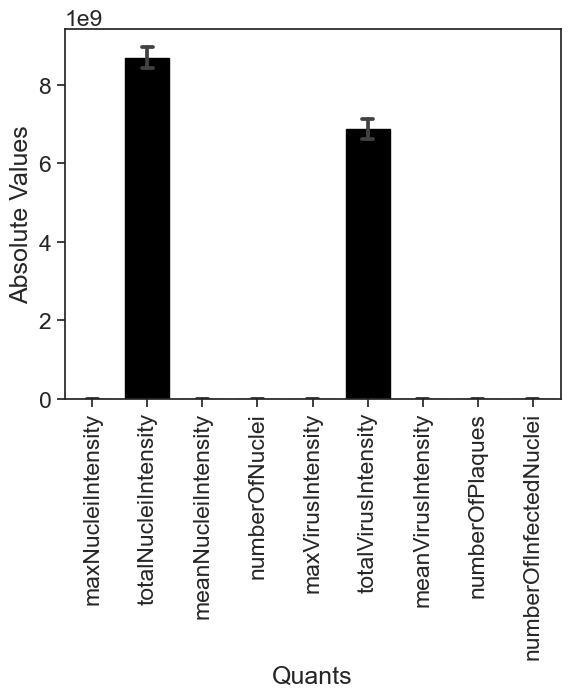

In [114]:
barplot_info_loss(abs_df)


In [33]:
# def lookup_objects(df, plq_object_readout):
#     filtered_df = df.loc[
#         matlab_results_object['wellCollumn'].str.contains(plq_object_readout.get_column(),
#                                                           case=True)]

#     filtered_df = filtered_df.loc[
#         matlab_results_object['wellRow'].str.contains(plq_object_readout.get_row(), case=True)]

#     #Y
#     df_closest = filtered_df.iloc[(
#         filtered_df['Centroid_1']-plq_object_readout.get_centroid()[0]).abs().argsort()[:1]]

#     #X
#     df_closest = df_closest.iloc[(
#         df_closest['Centroid_2']-plq_object_readout.get_centroid()[1]).abs().argsort()[:1]]
#     return df_closest


In [366]:
abs_df_object = pd.DataFrame()


In [367]:
matlab_results_object['wellCollumn'] = matlab_results_object['wellCollumn'].apply(str)


In [368]:
#Now for the readouts at the object level
well_row = []
well_column = []
area_abs = []
centroid_1_abs = []
centroid_2_abs = []
bbox_1_abs = []
bbox_2_abs = []
bbox_3_abs = []
bbox_4_abs = []
major_axis_length_abs = []
minor_axis_length_abs = []
eccentricity_abs = []
convex_area_abs = []
roundness_abs = []
peak_counts_abs = []
nuclei_in_plaque_abs = []
infected_nuclei_in_plaque_abs = []
max_intensity_GFP_abs = []
total_intensity_GFP_abs = []
mean_intensity_GFP_abs = []

for i in range(len(img_list_w2)):
    print(i)
    plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                        ['image_name'][i+1].split("/")[-1],
                            plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][i+1].split("/")[-1],
                            nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][i+1]),
                            plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][i+1]),
                            nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][i+1]),
                            plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][i+1]),
                            virus_params=params_w2)
    # print(plate_dict_w1['200601-zplate-g2']['image_name'][i+1])
    plq_objects = plq_image_readout.get_plaque_objects()
    # print(len(plq_objects))
    if len(plq_objects)==0:
        continue
    random_plq_id = np.random.randint(low=0, high =len(plq_objects),size=1)
    # print(random_plq_id)
    plq_object_readout = plq_image_readout.call_plaque_object_readout(plq_objects[random_plq_id[0]],
                                                                      params_w2)

    # df_closest = lookup_objects(matlab_results_object,plq_object_readout)
    # print(df_closest)

    # if len(df_closest)==0:
    #     continue
    well_row.append(plq_object_readout.get_row())
    well_column.append(plq_object_readout.get_column())
    area_abs.append(plq_object_readout.get_area())
    centroid_1_abs.append(plq_object_readout.get_centroid()[0])
    centroid_2_abs.append(plq_object_readout.get_centroid()[1])
    bbox_1_abs.append(plq_object_readout.get_bbox()[0])
    bbox_2_abs.append(plq_object_readout.get_bbox()[1])
    bbox_3_abs.append(plq_object_readout.get_bbox()[2])
    bbox_4_abs.append(plq_object_readout.get_bbox()[3])
    major_axis_length_abs.append(plq_object_readout.get_major_minor_axis_length()[0])
    minor_axis_length_abs.append(plq_object_readout.get_major_minor_axis_length()[1])
    eccentricity_abs.append(plq_object_readout.get_eccentricity())
    convex_area_abs.append(plq_object_readout.get_convex_area())
    roundness_abs.append(plq_object_readout.roundness())
    peak_counts_abs.append(len(plq_object_readout.get_number_of_peaks()))
    nuclei_in_plaque_abs.append(plq_object_readout.get_nuclei_in_plaque())
    infected_nuclei_in_plaque_abs.append(plq_object_readout.get_infected_nuclei_in_plaque())
    max_intensity_GFP_abs.append(plq_object_readout.get_max_intensity_GFP())
    total_intensity_GFP_abs.append(plq_object_readout.get_total_intensity_GFP())
    mean_intensity_GFP_abs.append(plq_object_readout.get_mean_intensity_GFP())


0
1


c:\Python311\Lib\site-packages\scipy\ndimage\_filters.py:187: RuntimeWarning: overflow encountered in scalar multiply
  sigma2 = sigma * sigma


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [369]:
print(matlab_results_object.columns)


Index(['Area', 'Centroid_1', 'Centroid_2', 'BoundingBox_1', 'BoundingBox_2',
       'BoundingBox_3', 'BoundingBox_4', 'MajorAxisLength', 'MinorAxisLength',
       'Eccentricity', 'ConvexArea', 'Roundness', 'numberOfPeaks',
       'numberOfNucleiInPlaque', 'numberOfInfectedNucleiInPlaque', 'wellRow',
       'wellCollumn', 'maxIntensityGFP', 'totalIntensityGFP', 'meanIntensity'],
      dtype='object')


In [370]:
abs_df_object['wellRow'] = well_row
abs_df_object['wellCollumn'] = well_column
abs_df_object['Area'] = area_abs
abs_df_object['Centroid_1'] = centroid_1_abs
abs_df_object['Centroid_2'] = centroid_2_abs
abs_df_object['BoundingBox_1'] = bbox_1_abs
abs_df_object['BoundingBox_2'] = bbox_2_abs
abs_df_object['BoundingBox_3'] = bbox_3_abs
abs_df_object['BoundingBox_4'] = bbox_4_abs
abs_df_object['MajorAxisLength'] = major_axis_length_abs
abs_df_object['MinorAxisLength'] = minor_axis_length_abs
abs_df_object['Eccentricity'] = eccentricity_abs
abs_df_object['ConvexArea'] = convex_area_abs
abs_df_object['Roundness'] = roundness_abs
abs_df_object['numberOfPeaks'] = peak_counts_abs
abs_df_object['numberOfNucleiInPlaque'] = nuclei_in_plaque_abs
abs_df_object['numberOfInfectedNucleiInPlaque'] = infected_nuclei_in_plaque_abs
abs_df_object['maxIntensityGFP'] = max_intensity_GFP_abs
abs_df_object['totalIntensityGFP'] = total_intensity_GFP_abs
abs_df_object['meanIntensity'] = mean_intensity_GFP_abs


In [374]:
abs_df_object

,wellRow,wellCollumn,Area,Centroid_1,Centroid_2,BoundingBox_1,BoundingBox_2,BoundingBox_3,BoundingBox_4,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Roundness,numberOfPeaks,numberOfNucleiInPlaque,numberOfInfectedNucleiInPlaque,maxIntensityGFP,totalIntensityGFP,meanIntensity
0,d,ata\200601-zplate-g2\2020-06-03\2072\200601-zp...,5533.0,243.788541,1673.185794,192,1737,120,110,122.122316,92.551540,0.652418,9084.0,0.265843,2,45.658824,39.670588,9206,18605208,48.959954
1,d,ata\200601-zplate-g2\2020-06-03\2072\200601-zp...,2077.0,752.055368,1535.411170,726,1571,57,69,75.184094,39.892309,0.847625,2780.0,0.330152,1,11.717647,9.341176,8964,5688988,29.711677
2,d,ata\200601-zplate-g2\2020-06-03\2072\200601-zp...,4752.0,713.586279,1926.309975,529,1977,358,84,420.385590,30.828951,0.997307,11643.0,0.044745,3,121.317647,44.941176,10440,18614555,109.010080
3,d,ata\200601-zplate-g2\2020-06-03\2072\200601-zp...,2367.0,1087.902408,758.980144,1042,802,84,94,113.932881,38.663435,0.940659,3859.0,0.189640,1,44.611765,28.623529,3465,5885774,48.376327
4,d,ata\200601-zplate-g2\2020-06-03\2072\200601-zp...,6976.0,1607.637758,1450.978498,1551,1520,124,127,146.324145,82.722664,0.824859,11050.0,0.281927,1,57.141176,41.176471,8677,27360123,57.242747
5,d,ata\200601-zplate-g2\2020-06-03\2072\200601-zp...,8397.0,508.054543,1941.083959,342,1987,322,100,319.625679,89.053853,0.960402,21535.0,0.094045,4,110.717647,79.811765,28597,37562544,103.623565
6,d,ata\200601-zplate-g2\2020-06-03\2072\200601-zp...,4082.0,538.084762,1494.608280,462,1523,135,56,129.573108,47.977095,0.928924,5651.0,0.243311,1,39.058824,30.682353,8286,12983582,51.768706
7,d,ata\200601-zplate-g2\2020-06-03\2072\200601-zp...,7171.0,639.733371,1930.927625,579,1979,137,113,143.531752,84.791469,0.806854,10374.0,0.289505,1,58.094118,56.000000,14907,29031160,62.177430
8,d,ata\200601-zplate-g2\2020-06-03\2072\200601-zp...,7784.0,1319.638361,732.109712,1247,782,149,101,149.422850,80.573844,0.842156,12019.0,0.305873,1,56.505882,50.388235,10702,30714419,61.925556


In [375]:
abs_df_object.shape


(9, 20)

In [376]:
iter = len(abs_df_object)
quants = list(abs_df_object.columns)
quants.pop(0)
quants.pop(0)
print(quants)
print(len(quants))
abs_iter_ls  = np.array([list(abs_df_object[quant]) for quant in quants]).flatten()

abs_df = pd.DataFrame({
        "Values": abs_iter_ls,
        "Quant": np.array([[quant]*iter for quant in quants]).flatten()
    })


['Area', 'Centroid_1', 'Centroid_2', 'BoundingBox_1', 'BoundingBox_2', 'BoundingBox_3', 'BoundingBox_4', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Roundness', 'numberOfPeaks', 'numberOfNucleiInPlaque', 'numberOfInfectedNucleiInPlaque', 'maxIntensityGFP', 'totalIntensityGFP', 'meanIntensity']
18


c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


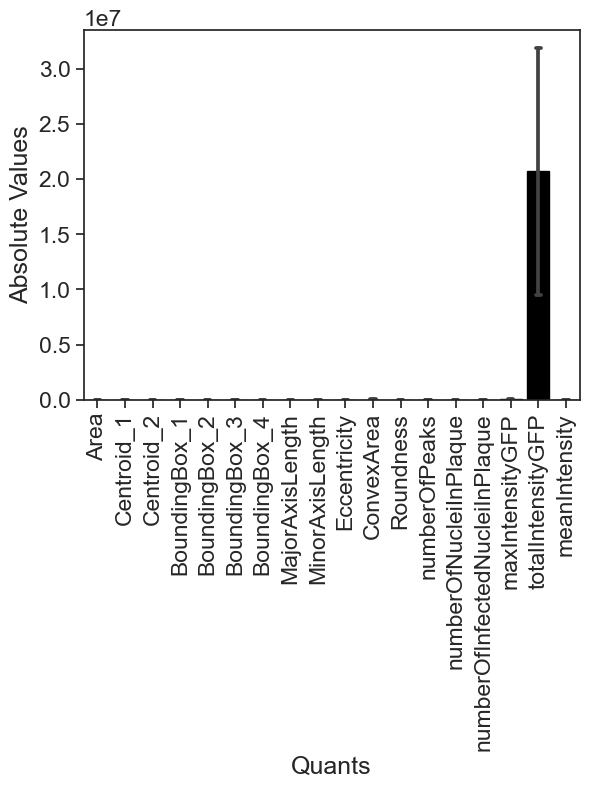

In [373]:
barplot_info_loss(abs_df)


#### ROUGH WORK

NameError: name 'virus_params_w2' is not defined

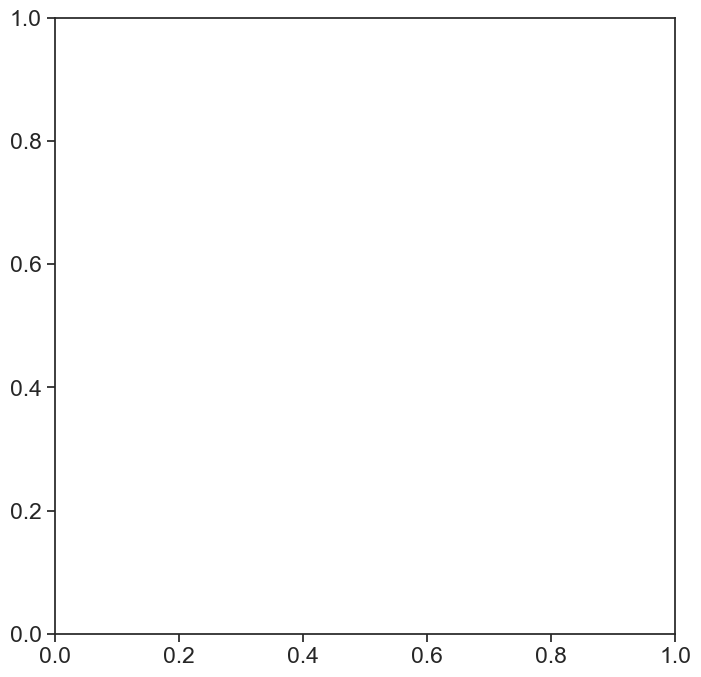

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(get_plaque_mask(TIFF.imread(os.path.join(exp.plate_folder,d,'2020-06-03','2072','200601-zplate-g2_J17_s1_w2.tif')),virus_params_w2)[0],cmap='gray')
plt.show()
